### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут

In [1]:
def loss_MSE(ai, y):
    return np.mean(np.square(y - ai))

def target_MSE(ai, y):
    return 2 *(ai - y)
    
def loss_exp(ai, y):
    return np.mean(np.exp(- y * ai))

def target_exp(ai, y):
    return -y * np.exp(- y * ai)
    
def loss_log(ai, y):
    return np.mean(np.log(1 + np.exp(- y * ai)))

def target_log(ai, y):
    return (- y * np.exp(-y * ai)) / (1 + np.exp(-y * ai))

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [2]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
from tqdm.notebook import tqdm

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
class MyGradientBoostingClassifier:

    def __init__(self, loss="logit", learning_rate=1, n_estimator=100, colsample=0.4, subsample=0.4, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimator
        self.colsample = colsample
        self.subsample = subsample
        self.arg_params = args
        self.kwarg_params = kwargs
        
        self.models = []
        self.init_value_ = None
        self.terminal_nodes_estimates_ = []
        pass
    
    def __calc_loss(self, models, X, y):
        ai = self._predict_est(X, models)
        if self.loss == "mse":
            return loss_MSE(ai, y)
        elif self.loss == "exponent":
            return loss_exp(ai, y)
        elif self.loss == "logit":
            return loss_log(ai, y)
        else:
            raise NotImplementedError()
        
    def __calc_target_grad(self, models, X, y):
        if len(models) == 0:
            return np.random.uniform(size=y.shape[0])
        ai = self._predict_est(X, models)
        if self.loss == "mse":
            return target_MSE(ai, y)
        elif self.loss == "exponent":
            return target_exp(ai, y)
        elif self.loss == "logit":
            return target_log(ai, y)
        else:
            raise NotImplementedError()
    
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        if init_model is not None:
            model = init_model()
        else:
            model = DummyRegressor(strategy="constant", constant=0.0)
        subsample_idx = np.random.choice(X.shape[0], round(X.shape[0] * self.subsample), replace=False)
        sub_X = X[subsample_idx]
        sub_y = y[subsample_idx]
        target_grad = self.__calc_target_grad(self.models, sub_X, sub_y)
        model.fit(sub_X, target_grad)
        self.models.append(model)
        
        for i in tqdm(range(self.n_estimators)):
            subsample_idx = np.random.choice(X.shape[0], round(X.shape[0] * self.subsample), replace=False)
            sub_X = X[subsample_idx]
            sub_y = y[subsample_idx]
            target_grad = self.__calc_target_grad(self.models, sub_X, sub_y)
            sub_feat = round(X.shape[1] * self.colsample)
            model = base_model(max_features=sub_feat, *self.arg_params, **self.kwarg_params)
            model.fit(sub_X, target_grad)
            self.models.append(model)
            train_loss = self.__calc_loss(self.models, sub_X, target_grad)
            #print(f"Iter: {i}, train_loss: {train_loss}")
        return self
    
    def _predict_est(self, X, models=None):
        if models is None:
            models = self.models
        assert models is not None
        pred = models[0].predict(X)
        for m in models[1:]:
            pred += self.learning_rate * m.predict(X)
        return pred / len(models)

    def predict(self, X, models=None):
        if models is None:
            models = self.models
        assert models is not None
        pred = models[0].predict(X)
        for m in models[1:]:
            pred += self.learning_rate * m.predict(X)
        return np.around(-pred / len(models)).astype(int)

In [597]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [598]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)
print(X_train.shape, y_train.shape)

(160, 13) (160,)


In [599]:
my_clf.fit(X_train, y_train, DecisionTreeRegressor)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.9444444444444444
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [8]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [9]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [612]:
est = [20, 60, 100, 200, 300]
accuracy = []

for n_estimators in est:
    my_clf = MyGradientBoostingClassifier(learning_rate=1, n_estimator=n_estimators)
    my_clf.fit(X_train, y_train, DecisionTreeRegressor)
    pred = my_clf.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy.append(acc)
    print(f"n_estimators: {n_estimators} accuracy: {acc}")

n_estimators: 20 accuracy: 0.7916666666666666
n_estimators: 60 accuracy: 0.814922480620155
n_estimators: 100 accuracy: 0.8187984496124031
n_estimators: 200 accuracy: 0.8192829457364341
n_estimators: 300 accuracy: 0.8217054263565892


In [54]:
import matplotlib.pyplot as plt

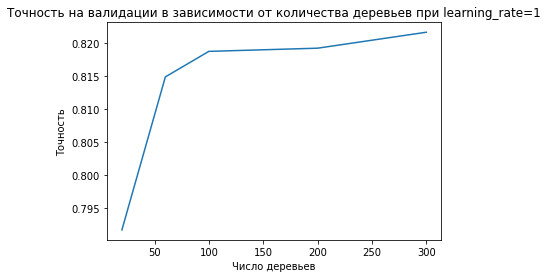

In [614]:
plt.title('Точность на валидации в зависимости от количества деревьев при learning_rate=1')
plt.xlabel('Число деревьев')
plt.ylabel('Точность')
plt.plot(est, accuracy)

In [616]:
subs = [0.2, 0.4, 0.6, 0.8, 1]
accuracy = []

for subsample in subs:
    my_clf = MyGradientBoostingClassifier(learning_rate=1, n_estimator=100, subsample=subsample)
    my_clf.fit(X_train, y_train, DecisionTreeRegressor)
    pred = my_clf.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy.append(acc)
    print(f"subsample: {subsample} accuracy: {acc}")

subsample: 0.2 accuracy: 0.8057170542635659
subsample: 0.4 accuracy: 0.812015503875969
subsample: 0.6 accuracy: 0.8221899224806202
subsample: 0.8 accuracy: 0.8357558139534884
subsample: 1 accuracy: 0.8435077519379846


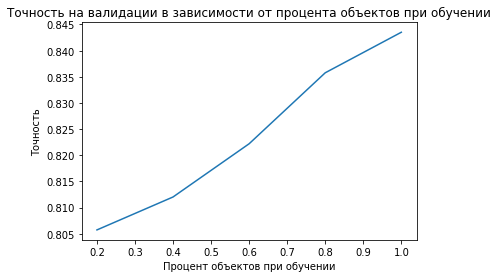

In [617]:
plt.title('Точность на валидации в зависимости от процента объектов при обучении')
plt.xlabel('Процент объектов при обучении')
plt.ylabel('Точность')
plt.plot(subs, accuracy)

In [619]:
cols = [0.2, 0.4, 0.6, 0.8, 1]
accuracy = []

for colsample in cols:
    my_clf = MyGradientBoostingClassifier(learning_rate=1, n_estimator=100, subsample=1, colsample=colsample)
    my_clf.fit(X_train, y_train, DecisionTreeRegressor)
    pred = my_clf.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy.append(acc)
    print(f"colsample: {colsample} accuracy: {acc}")

colsample: 0.2 accuracy: 0.8367248062015504
colsample: 0.4 accuracy: 0.8420542635658915
colsample: 0.6 accuracy: 0.8459302325581395
colsample: 0.8 accuracy: 0.8396317829457365
colsample: 1 accuracy: 0.8304263565891473


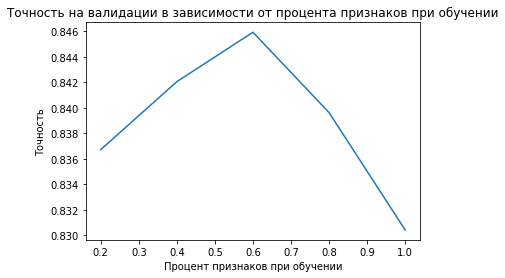

In [620]:
plt.title('Точность на валидации в зависимости от процента признаков при обучении')
plt.xlabel('Процент признаков при обучении')
plt.ylabel('Точность')
plt.plot(cols, accuracy)

In [625]:
depth = [3, 5, 7, 10, 20, 30, 40, 50]
accuracy = []

for max_depth in depth:
    my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1, n_estimator=100, subsample=1, colsample=0.6, max_depth=max_depth)
    my_clf.fit(X_train, y_train, DecisionTreeRegressor)
    pred = my_clf.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy.append(acc)
    print(f"max_depth: {max_depth} accuracy: {acc}")

max_depth: 3 accuracy: 0.7059108527131783
max_depth: 5 accuracy: 0.7427325581395349
max_depth: 7 accuracy: 0.7834302325581395
max_depth: 10 accuracy: 0.814437984496124
max_depth: 20 accuracy: 0.8386627906976745
max_depth: 30 accuracy: 0.8401162790697675
max_depth: 40 accuracy: 0.8425387596899225
max_depth: 50 accuracy: 0.8381782945736435


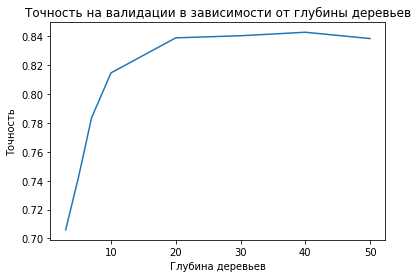

In [626]:
plt.title('Точность на валидации в зависимости от глубины деревьев')
plt.xlabel('Глубина деревьев')
plt.ylabel('Точность')
plt.plot(depth, accuracy)

In [627]:
lr = [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
accuracy = []

for learning_rate in lr:
    my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=learning_rate, n_estimator=100, subsample=1, colsample=0.6, max_depth=30)
    my_clf.fit(X_train, y_train, DecisionTreeRegressor)
    pred = my_clf.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy.append(acc)
    print(f"learning_rate: {learning_rate} accuracy: {acc}")

learning_rate: 0.01 accuracy: 0.5780038759689923
learning_rate: 0.1 accuracy: 0.5780038759689923
learning_rate: 0.3 accuracy: 0.5780038759689923
learning_rate: 0.5 accuracy: 0.5780038759689923
learning_rate: 0.7 accuracy: 0.5780038759689923
learning_rate: 0.9 accuracy: 0.8008720930232558
learning_rate: 1 accuracy: 0.8420542635658915


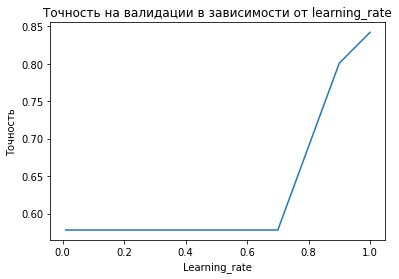

In [628]:
plt.title('Точность на валидации в зависимости от learning_rate')
plt.xlabel('Learning_rate')
plt.ylabel('Точность')
plt.plot(lr, accuracy)

**Итого параметры: loss = "logit", learning_rate = 1, n_estimators = 100, subsample = 1.0, colsample = 0.6, max_depth = 30**

In [20]:
my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1, n_estimator=100, subsample=1, colsample=0.6, max_depth=30)
my_clf.fit(X_train, y_train, DecisionTreeRegressor)
finacc = accuracy_score(my_clf.predict(X_test), y_test)
print(finacc)

  0%|          | 0/100 [00:00<?, ?it/s]

0.8575581395348837


## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1, n_estimator=100, subsample=1, colsample=0.6, n_estimators=20)
my_clf.fit(X_train, y_train, RandomForestRegressor)
print(finacc)
print(accuracy_score(my_clf.predict(X_test), y_test))

  0%|          | 0/100 [00:00<?, ?it/s]

0.8575581395348837
0.8420542635658915


In [38]:
my_clfs = []
for nest in tqdm(range(50)):
    idx = np.random.choice(X_train.shape[0], X_train.shape[0], replace=True)
    X_sub = X_train[idx]
    y_sub = y_train[idx]
    my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1, n_estimator=100, subsample=1, colsample=0.6)
    my_clf.fit(X_sub, y_sub, DecisionTreeRegressor)
    my_clfs.append(my_clf)
print(finacc)
pred = my_clfs[0].predict(X_test)
for m in my_clfs[1:]:
    pred += m.predict(X_test)
pred = (np.around(pred/len(my_clfs))).astype(int)
print(accuracy_score(pred, y_test))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.8575581395348837
0.8498062015503876


**Вывод**: BagBoo и BooBag имеют больше гиперпараметров для настройки (отдельно гиперпараметры baggingа и отдельно boostingа), что делает их сложнее в применении. В принципе, при хорошей настройке результат должен быть лучше, но в данном случае добиться улучшения не удалось.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [67]:
res = {}
my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1, n_estimator=100, subsample=1, colsample=0.6, max_depth=30)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=None)
acc = accuracy_score(my_clf.predict(X_test), y_test)
res['Constant'] = acc
print(f"init_model: Constant, accuracy: {acc}")

  0%|          | 0/100 [00:00<?, ?it/s]

init_model: Constant, accuracy: 0.8580426356589147


In [68]:
my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1, n_estimator=100, subsample=1, colsample=0.6, max_depth=30)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=LinearRegression)
acc = accuracy_score(my_clf.predict(X_test), y_test)
res['LinearRegression'] = acc
print(f"init_model: LinearRegression, accuracy: {acc}")

  0%|          | 0/100 [00:00<?, ?it/s]

init_model: LinearRegression, accuracy: 0.8541666666666666


In [69]:
my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1, n_estimator=100, subsample=1, colsample=0.6, max_depth=30)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=KNeighborsRegressor)
acc = accuracy_score(my_clf.predict(X_test), y_test)
res['KNeighborsRegressor'] = acc
print(f"init_model: KNeighborsRegressor, accuracy: {acc}")

  0%|          | 0/100 [00:00<?, ?it/s]

init_model: KNeighborsRegressor, accuracy: 0.8546511627906976


In [70]:
my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1, n_estimator=100, subsample=1, colsample=0.6, max_depth=30)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=DecisionTreeRegressor)
acc = accuracy_score(my_clf.predict(X_test), y_test)
res['DecisionTreeRegressor'] = acc
print(f"init_model: DecisionTreeRegressor, accuracy: {acc}")

  0%|          | 0/100 [00:00<?, ?it/s]

init_model: DecisionTreeRegressor, accuracy: 0.8498062015503876


In [71]:
my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1, n_estimator=100, subsample=1, colsample=0.6, max_depth=30)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=RandomForestRegressor)
acc = accuracy_score(my_clf.predict(X_test), y_test)
res['RandomForestRegressor'] = acc
print(f"init_model: RandomForestRegressor, accuracy: {acc}")

  0%|          | 0/100 [00:00<?, ?it/s]

init_model: RandomForestRegressor, accuracy: 0.8556201550387597


In [72]:
my_clf = MyGradientBoostingClassifier(loss='logit', learning_rate=1, n_estimator=10, subsample=1, colsample=0.6, max_depth=30)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=SVR)
acc = accuracy_score(my_clf.predict(X_test), y_test)
res['SVR'] = acc
print(f"init_model: SVR, accuracy: {acc}")

  0%|          | 0/10 [00:00<?, ?it/s]

init_model: SVR, accuracy: 0.5780038759689923


**Вывод**: наибольший потенциал имеет использование RandomForestRegressor. Проблема та же -- больше гиперпараметров, требуется лучшая настройка.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

